Write a colab pytorch from scratch - 3 layer deep neural network for non linear regression without using pytorch builtin layer functionality 



**3 Layer Deep NeuralNetwork for non linear regression without using pytorch **

#import necessary libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

#input sample data

In [2]:
def get_true_labels(X, weights_true, bias_true):
  return (-3 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

In [3]:
n_samples = 120
input_dim = 3
output_dim = 2

torch.manual_seed(123)
max = 1
min = -1
X = (max - min) * torch.rand((n_samples, input_dim)) + min
print('Sample X: ' + str(X[:2]))

weights_true = torch.tensor([[5., -1., 4], [1, 2, 3]])
bias_true = torch.tensor([[1.], [1.]])

y_true = get_true_labels(X, weights_true, bias_true)
print('Sample y: ' + str(y_true[:2]))

Sample X: tensor([[-0.4078,  0.0331, -0.4967],
        [ 0.3771, -0.8521,  0.7330]])
Sample y: tensor([[-8.5096, -3.5570],
        [ 0.2663, -7.7467]])


#Plotting the 3D data

In [4]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

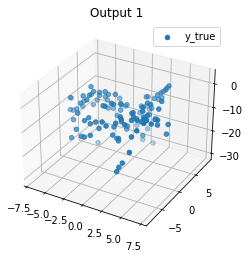

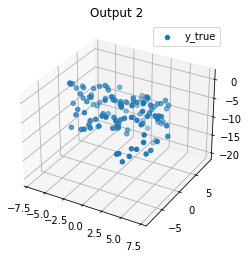

In [5]:
plot_3d('Output 1', X, y_true[:,0])
plot_3d('Output 2', X, y_true[:,1])

#Build Neural Network

In [6]:
# Define Mean Squared Error (MSE) class to compute error and gradient
class MSE:
  def __init__(self, y_pred, y_true):
    # Store predicted and true values
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    # Compute MSE error
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    # Compute gradient of MSE error w.r.t. predicted values
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient

# Define Layer class for a neural network layer
class Layer:
  def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
    # Initialize layer with random weights and bias
    self.num_input_nodes = num_input_nodes
    self.num_output_nodes = num_output_nodes
    max = 1
    min = -1
    self.weights = (max - min) * torch.rand((num_input_nodes, num_output_nodes), requires_grad=True) + min
    self.bias = torch.rand((1), requires_grad=True)
    self.X = torch.ones((num_input_nodes))
    # Set activation function
    if activation == 'relu':
      self.activation = Relu()
    else: 
      self.activation = None
  
  def forward(self, X):
    # Compute output of layer
    self.X = X
    self.Z = self.X @ self.weights + self.bias
    self.weights.retain_grad()
    self.bias.retain_grad()
    # Pass output through activation function
    if self.activation == None:
      return self.Z 
    else:
      return self.activation.forward(self.Z)

  def backward(self):
    # Compute gradients of layer parameters w.r.t. loss using auto differentiation
    self.dJdW = self.weights.grad
    self.dJdb = self.bias.grad

  def update(self, lr):
    # Update layer parameters using gradient descent with given learning rate
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    # Return string representation of layer with input and output node counts, activation function, inputs, weights, and bias
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.num_input_nodes, self.num_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

# Define ReLU activation function
class Relu:
  def __init__(self):
    self.input = torch.tensor([])

  def forward(self, input):
    # Compute output of ReLU activation function
    self.input = input
    self.output = torch.clamp(self.input, min=0)
    return self.output
  
  def backward(self, upstream_gradient):
    # Compute gradient of ReLU activation function w.r.t. loss using auto differentiation
    return
  
  def update(self, lr):
    # No update needed for ReLU activation function
    return

  def __str__(self):
    # Return string representation of ReLU activation function
    return 'ReLU'

class NeuralNet:
  def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
    # Initialize the network's hyperparameters
    self.num_inputs = num_inputs
    self.num_hidden = num_hidden
    self.num_outputs = num_outputs

    # Define the layers of the network using the specified architecture
    layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    self.layers = []
    for i in range(len(layers[:-1])):
      # Create a layer with the specified number of inputs, outputs, and activation function
      if i == len(layers[:-1]) - 1:
        # Don't add an activation function to the output layer because this is a regression problem
        self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation))

    # Print network architecture for debugging
    print('Neural Net Architecture:')
    for i, layer in enumerate(self.layers):
      print('=== Layer {} ==='.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    # Compute the forward pass of the network
    curr_out = inputs
    for l in self.layers:
      curr_out = l.forward(curr_out)

    return curr_out
  
  def backward(self, y_pred, y_true):
    # Compute the backward pass of the network
    external_grad = torch.ones(y_true.shape)

    # Compute the mean squared error between the predicted and true outputs
    mse = MSE(y_pred, y_true)
    error = mse.get_error()

    # Print the error for debugging purposes
    print('Error: ', mean_squared_error(y_true, y_pred.detach().numpy()))

    # Backpropagate the error through the network
    error.backward(gradient=external_grad, retain_graph=True)
    for layer in reversed(self.layers):
      layer.backward()
    
  def update(self, lr):
    # Update the weights and biases of the network using the specified learning rate
    for layer in self.layers:
      layer.update(lr)
  
  def fit(self, X, y_true, epochs):
    # Train the network using the specified input, output, and number of epochs
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr) 

  def __str__(self):
    # Print the layers of the network
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)



#hyperparameters

In [9]:
epochs = 450
lr = 0.01

n_inputs = X.shape[1]
n_outputs = y_true.shape[1]

#Training neural network with Relu

In [10]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLU
Inputs:
tensor([1., 1.])
Weights:
tensor([[-0.0861,  0.3277, -0.5626, -0.8685],
        [ 0.4774, -0.6618, -0.5628,  0.8296],
        [-0.6589, -0.8115,  0.7601, -0.4772]], grad_fn=<AddBackward0>)
Bias:tensor([0.5325], requires_grad=True)
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLU
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.9962, -0.3990,  0.9314],
        [ 0.7945,  0.7723,  0.2966],
        [-0.4507,  0.6296, -0.6850],
        [-0.5826, -0.4821,  0.4325]], grad_fn=<AddBackward0>)
Bias:tensor([0.5689], requires_grad=True)
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.6362,  0.6572],
        [ 0.0584,  0.5829],
        [-0.7227, -0.9557]], grad_fn=<AddBackward0>)
Bias:tensor([0.0927], requires_grad=True)

Error:  65.005615
Error:  51.84447
Error:  39.465088
Error:  28.459019
Error:  25.608269
Error:  24.758259
Error:  24.071663
Error:  23.

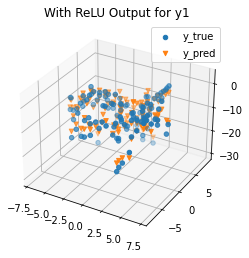

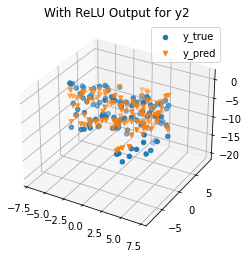

In [11]:
plot_3d('With ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('With ReLU Output for y2', X, y_true[:,1], y_pred[:,1])

#Train neural network with ReLU

In [12]:
nn = NeuralNet(num_inputs=n_inputs, num_hidden=[4, 3], num_outputs=n_outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
Layer: (3,4) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.5518,  0.9195, -0.2766,  0.5533],
        [-0.7145, -0.0189, -0.0060, -0.2895],
        [-0.4847,  0.4692, -0.0871, -0.1982]], grad_fn=<AddBackward0>)
Bias:tensor([0.8474], requires_grad=True)
=== Layer 1 ===
Layer: (4,3) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[-0.7594,  0.6530,  0.8881],
        [-0.6143, -0.9475,  0.1391],
        [-0.7606,  0.4182, -0.7975],
        [-0.7805,  0.2705, -0.2563]], grad_fn=<AddBackward0>)
Bias:tensor([0.0574], requires_grad=True)
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
tensor([1., 1.])
Weights:
tensor([[ 0.3902,  0.3532],
        [ 0.1348,  0.6534],
        [-0.4015,  0.9127]], grad_fn=<AddBackward0>)
Bias:tensor([0.1189], requires_grad=True)

Error:  61.507904
Error:  48.5506
Error:  37.984577
Error:  34.74481
Error:  33.228687
Error:  31.963985
Error:  30.813835
Error:  29.74

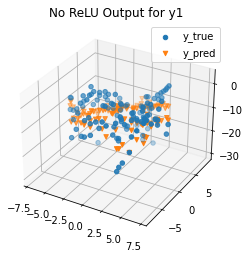

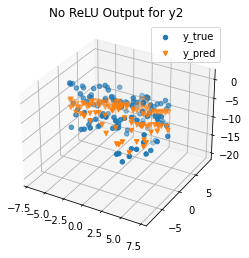

In [13]:
plot_3d('No ReLU Output for y1', X, y_true[:,0], y_pred[:,0])
plot_3d('No ReLU Output for y2', X, y_true[:,1], y_pred[:,1])